# Project COGS 189: EEG-Based Attention State Classification Using Machine Learning


Mohsin Khawaja A17643078

Samer Ahmed A17001877

Xavier Lopez A17068366

#### Recommended Environment Setup
```  conda create --name "cogs189" python=3.9   ```

``` conda activate cogs189 ```

#### Now run the following cell to install the requirements.txt

In [2]:
# Install necessary libraries (run only once per session)
import os
if not os.path.exists("requirements_installed.txt"):
    import sys
    !{sys.executable} -m pip install -r requirements.txt --quiet
    with open("requirements_installed.txt", "w") as f:
        f.write("installed")

#### Test to see if the installation worked by importing the needed libraries

In [3]:
import zipfile
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, butter, lfilter
import mne  # EEG processing library

#### Proceeding to handling the data

1. First, download the zip file locally and place it into the same folder as project. (Next to this notebook file.)

* Due to the large file size even when zipped, Git/Github is not viable solution for holding/transfering.

In [5]:
zipped_name = "data_preprocessed_python.zip"
unzipped_folder = "data_preprocessed_python"

if not os.path.exists(unzipped_folder):
    print("Extracting files...")
    with zipfile.ZipFile(zipped_name, 'r') as zip_ref:
        zip_ref.extractall(os.getcwd())
    print(f"Extracted files into: {os.getcwd()}")
else:
    print("Files already extracted.")

files = [f for f in os.listdir(unzipped_folder) if f.endswith(".dat")]
print(f"Found {len(files)} EEG data files in {unzipped_folder}.")

Files already extracted.
Found 32 EEG data files in data_preprocessed_python.


### Load & Structure EEG Data

In [6]:
all_eeg_data = []
all_labels = []

for file in files:
    file_path = os.path.join(unzipped_folder, file)
    with open(file_path, 'rb') as f:
        participant_data = pickle.load(f, encoding='latin1')
        
        eeg_data = participant_data['data'][:, :32, :]
        labels = participant_data['labels']
        
        all_eeg_data.append(eeg_data)
        all_labels.append(labels)

all_eeg_data = np.array(all_eeg_data)
all_labels = np.array(all_labels)

print("Final EEG Dataset Shape:", all_eeg_data.shape)
print("Final Labels Shape:", all_labels.shape)

Final EEG Dataset Shape: (32, 40, 32, 8064)
Final Labels Shape: (32, 40, 4)


### Visualize a Sample EEG Signal

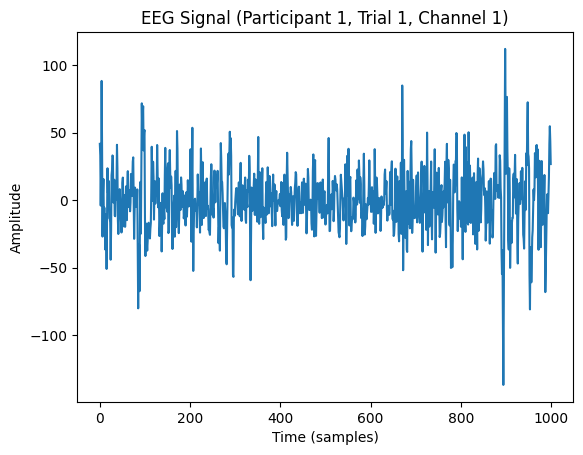

In [5]:
participant = 0
trial = 0
channel = 0

plt.plot(all_eeg_data[participant, trial, channel, :1000])  # First 1000 timepoints
plt.title(f"EEG Signal (Participant {participant+1}, Trial {trial+1}, Channel {channel+1})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

### Apply EEG Preprocessing

#### Check the frequency spectrum

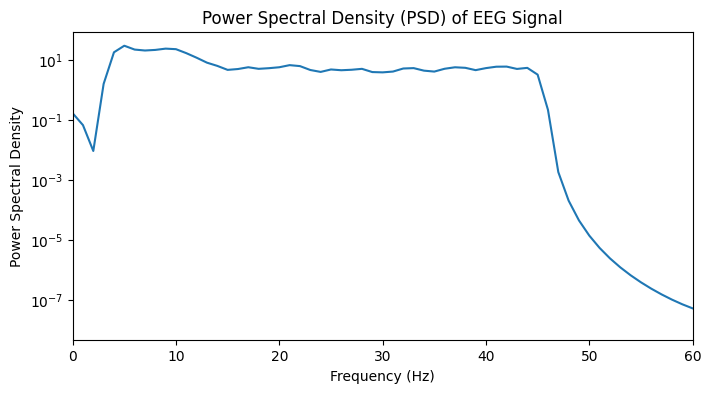

In [6]:
eeg_signal = all_eeg_data[0, 0, 0, :]

fs = 128
freqs, psd = welch(eeg_signal, fs, nperseg=fs)

plt.figure(figsize=(8, 4))
plt.semilogy(freqs, psd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectral Density (PSD) of EEG Signal")
plt.xlim(0, 60)
plt.show()

The Power Spectral Density (PSD) plot confirms that the EEG signal is already bandpass filtered between 4 Hz and 45 Hz. There is no significant power in frequencies below 4 Hz or above 45 Hz, meaning the preprocessed dataset has already removed unwanted frequency components.

### Segment EEG into Time Windows

In [7]:
def segment_data_per_trial(data, window_size=256, step_size=128):
    segmented_trials = []

    for participant in range(data.shape[0]):
        participant_segments = []
        for trial in range(data.shape[1]):
            segments = []
            trial_data = data[participant, trial]
            for start in range(0, trial_data.shape[-1] - window_size, step_size):
                segments.append(trial_data[:, start:start + window_size])
            participant_segments.append(np.array(segments))
        segmented_trials.append(np.array(participant_segments))

    return np.array(segmented_trials)

segmented_eeg = segment_data_per_trial(all_eeg_data)

print("Corrected Segmented EEG Shape:", segmented_eeg.shape)
# Expected: (32, 40, 61, 32, 256)

Corrected Segmented EEG Shape: (32, 40, 61, 32, 256)


### Extract Frequency Features

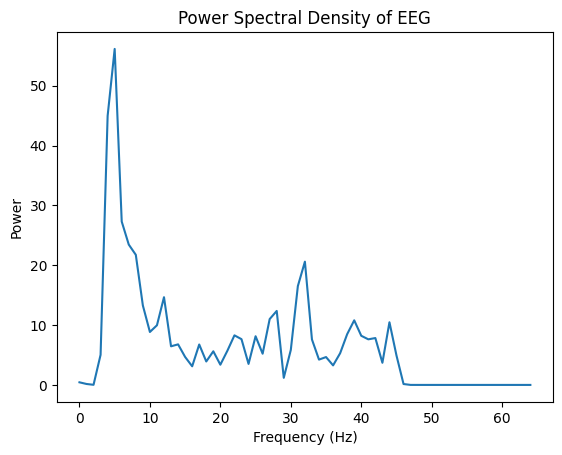

In [ ]:
def compute_psd(eeg_signal, fs=128):
    freqs, psd = welch(eeg_signal, fs, nperseg=fs)  # Compute Power Spectral Density
    return freqs, psd

sample_eeg_segment = segmented_eeg[0, 0, 0, 0, :]  # (participant, trial, segment, channel, time)

freqs, psd = compute_psd(sample_eeg_segment)

plt.plot(freqs, psd)
plt.title("Power Spectral Density of EEG")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.show()

### Frequency Band Power Extraction Processing

In [11]:
def extract_band_power(psd, freqs, bands={'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)}):
    """
    Extracts average power in specified EEG bands from the Power Spectral Density (PSD).
    """
    band_powers = {}
    for band, (low, high) in bands.items():
        idx = np.where((freqs >= low) & (freqs <= high))
        band_powers[band] = np.mean(psd[idx])
    return band_powers

features_list = []

for participant in range(segmented_eeg.shape[0]):
    for trial in range(segmented_eeg.shape[1]):
        for segment in range(segmented_eeg.shape[2]):
            segment_features = {}
            
            for channel in range(segmented_eeg.shape[3]):
                eeg_signal = segmented_eeg[participant, trial, segment, channel, :]
                
                freqs, psd = compute_psd(eeg_signal)

                band_powers = extract_band_power(psd, freqs)

                for band, power in band_powers.items():
                    segment_features[f"Ch{channel+1}_{band}"] = power
            
            segment_features["participant"] = participant
            segment_features["trial"] = trial
            segment_features["segment"] = segment
            
            features_list.append(segment_features)

df_features = pd.DataFrame(features_list)

print(df_features.head())

   Ch1_theta  Ch1_alpha  Ch1_beta  Ch1_gamma  Ch2_theta  Ch2_alpha  Ch2_beta  \
0  34.719148  12.491228  6.088634   8.127150  20.567578  10.421573  7.038770   
1  14.837643  16.194875  7.532733   5.744115  11.713629  15.195857  8.080758   
2   6.482831   7.567323  5.865260   4.017712   4.587964   7.540463  6.146646   
3   5.721155   7.290100  5.816388   3.746272   5.755174   7.452777  5.528686   
4   7.524442   7.817093  5.681470   8.981711   7.578799   7.205118  5.133516   

   Ch2_gamma  Ch3_theta  Ch3_alpha  ...  Ch31_alpha  Ch31_beta  Ch31_gamma  \
0   8.819701  53.883115  11.240943  ...   17.421523   8.610681   10.923950   
1   5.997644  24.407153  13.682537  ...   20.455081   9.941843    7.864048   
2   3.905201  12.155751   6.274768  ...   11.212588   7.442963    5.178248   
3   3.533932   3.456029   4.323512  ...    9.900873   5.966563    4.160738   
4   8.492576   5.395734   3.455396  ...    8.638751   6.190805    9.128381   

   Ch32_theta  Ch32_alpha  Ch32_beta  Ch32_gamma  

#### Export to CSV

In [12]:
df_features.to_csv("eeg_extracted_features.csv", index=False)

print("Feature extraction complete. Data saved as eeg_extracted_features.csv")

Feature extraction complete. Data saved as eeg_extracted_features.csv
